## Passion Fruits, Object detection and localization model

In [1]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!cp 'drive/My Drive/Passion_Fruit_Dataset/Train_Images.zip' Train_Images.zip
!cp 'drive/My Drive/Passion_Fruit_Dataset/Test_Images.zip' Test_Images.zip

!unzip -q Train_Images.zip 
!unzip -q Test_Images.zip 

### Read the csv files

### Train

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Passion_Fruit_Dataset/Train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [5]:
train_df.shape

(3906, 6)

In [6]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

### Test

In [7]:
test_df = pd.read_csv("/content/drive/MyDrive/Passion_Fruit_Dataset/Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [8]:
test_df.shape

(931, 1)

In [9]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [ ]:
# train_df['xmax'] = train_df['xmin']+train_df1['width']
# train_df['ymax'] = train_df['ymin']+train_df['height']

In [ ]:
# test_df = test_df.loc[:2]

- Encode the classes from str to int

In [10]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,3,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0


In [11]:
xmax = train_df['xmin']+train_df['width']
train_df.insert(4, column='xmax', value=xmax)

In [12]:
ymax = train_df['ymin']+train_df['height']
train_df.insert(5, column='ymax', value=ymax)

In [13]:
train_df.head()

,Image_ID,class,xmin,ymin,xmax,ymax,width,height
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0,248.0,302.5
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5,233.5,182.0


In [14]:
train_df.dtypes


Image_ID     object
class         int64
xmin        float64
ymin        float64
xmax        float64
ymax        float64
width       float64
height      float64
dtype: object

In [15]:
#@title Default title text
df = train_df.copy() # create a copy of the train df

In [24]:
path = '/content/Train_Images/'
path2 = '/content/Test_Images/'

In [25]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [26]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [27]:
name = df.Image_ID.unique()[0]


   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


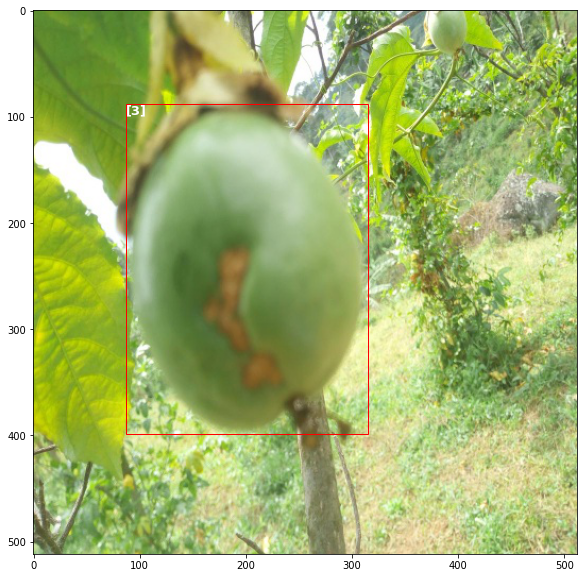

In [28]:
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


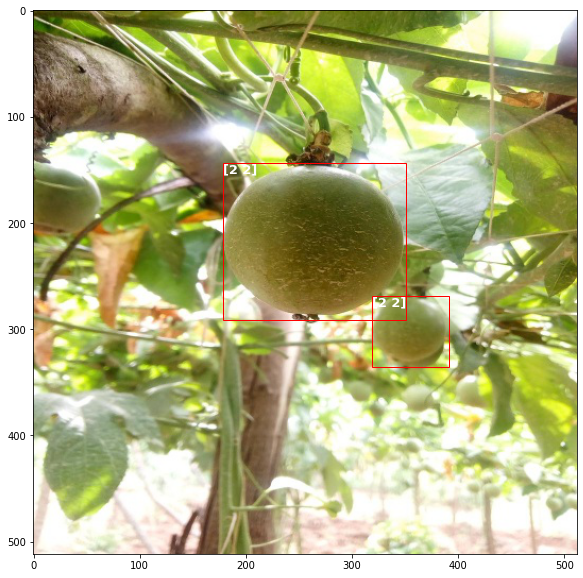

In [29]:
name = df.Image_ID.unique()[700]
# name = df.Image_ID.unique()[9]
plot_image(name)

    xmin  ymin   xmax   ymax
8  168.0  95.5  508.0  298.0


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


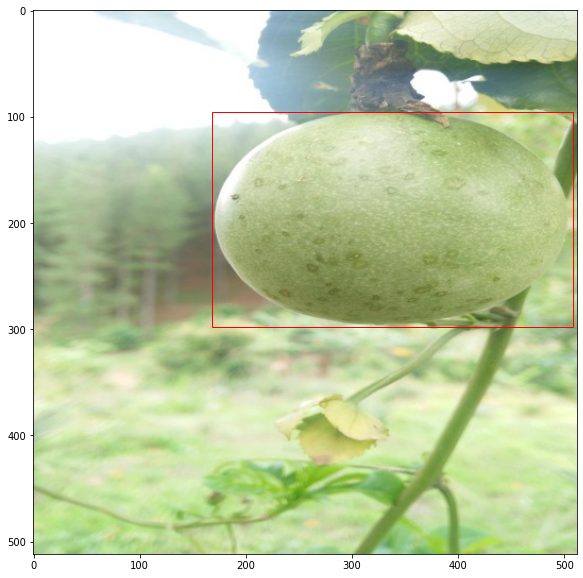

In [30]:
name = df.Image_ID.unique()[7]
plot_image(name)

In [31]:
df.drop('width', inplace=True, axis=1)
df.drop('height', inplace=True, axis=1)
df.head()

,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5


In [32]:
df = df.to_numpy()
df = df.tolist()

In [33]:
data = []
labels = []
bboxes = []
imagePaths = []

In [34]:
for row in df:
  imageId, label, xmin, ymin, xmax, ymax = row
  imagePath = '/content/Train_Images/'+imageId + '.jpg'

  #load image
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]

  
  xmin  = float(xmin) / w
  ymin  = float(ymin) / h
  xmax  = float(xmax) / w
  ymax  = float(ymax) / h

  #load and preproess image
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)

  data.append(image)
  labels.append(label)
  bboxes.append((xmin, ymin, xmax, ymax))
  imagePaths.append(imagePath)

In [35]:
#convert data to nupy array
#scale image data to 0-1
data = np.array(data, dtype='float32')/255.0
labels = np.array(labels)
bboxes = np.array(bboxes,dtype='float32')
imagePaths = np.array(imagePaths)

#perform onehot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [36]:
image = np.expand_dims(data[0],axis=1)
image

array([[[[0.36862746, 0.5411765 , 0.19215687],
         [0.37254903, 0.5568628 , 0.19607843],
         [0.36862746, 0.5647059 , 0.19215687],
         ...,
         [0.6156863 , 0.7137255 , 0.49019608],
         [0.62352943, 0.7254902 , 0.4862745 ],
         [0.6       , 0.7137255 , 0.45490196]]],


       [[[0.37254903, 0.54509807, 0.19607843],
         [0.3764706 , 0.56078434, 0.2       ],
         [0.36078432, 0.5568628 , 0.18431373],
         ...,
         [0.6901961 , 0.77254903, 0.5411765 ],
         [0.6784314 , 0.7490196 , 0.52156866],
         [0.6431373 , 0.72156864, 0.49019608]]],


       [[[0.38039216, 0.5568628 , 0.2       ],
         [0.3764706 , 0.56078434, 0.2       ],
         [0.36078432, 0.5529412 , 0.19215687],
         ...,
         [0.654902  , 0.7254902 , 0.49019608],
         [0.6313726 , 0.6862745 , 0.45490196],
         [0.69411767, 0.73333335, 0.5294118 ]]],


       ...,


       [[[0.7607843 , 0.8627451 , 0.58431375],
         [0.7607843 , 0.8666667 , 0.596

In [37]:
del image

In [38]:
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.2, random_state=34)


(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [39]:
rn50v2 = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

rn50v2.trainable = False

flatten = rn50v2.output
flatten = Flatten()(flatten)

94683136/94668760 [==============================] - 2s 0us/step


In [40]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


vgg.trainable = False


flatten = vgg.output
flatten = Flatten()(flatten)

58900480/58889256 [==============================] - 1s 0us/step


In [52]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))



ValueError: ignored

In [42]:

losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}


lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

opt = Adam(learning_rate=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"],
    loss_weights=lossWeights)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [43]:
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [44]:
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=32,
	epochs=20,
	verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save('/content/drive/MyDrive/Passion_Fruit_Dataset/model2_rn50v2base', save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open('/content/drive/MyDrive/Passion_Fruit_Dataset/model2_binarizer', "wb")
f.write(pickle.dumps(lb))
f.close()

Epoch 1/20
98/98 [==============================] - 26s 135ms/step - loss: 0.8595 - bounding_box_loss: 0.0268 - class_label_loss: 0.8327 - bounding_box_accuracy: 0.7087 - class_label_accuracy: 0.6306 - val_loss: 0.4380 - val_bounding_box_loss: 0.0244 - val_class_label_loss: 0.4136 - val_bounding_box_accuracy: 0.7634 - val_class_label_accuracy: 0.8402
Epoch 2/20
98/98 [==============================] - 9s 91ms/step - loss: 0.4729 - bounding_box_loss: 0.0215 - class_label_loss: 0.4514 - bounding_box_accuracy: 0.7676 - class_label_accuracy: 0.8255 - val_loss: 0.2897 - val_bounding_box_loss: 0.0245 - val_class_label_loss: 0.2652 - val_bounding_box_accuracy: 0.7519 - val_class_label_accuracy: 0.9028
Epoch 3/20
98/98 [==============================] - 9s 91ms/step - loss: 0.3129 - bounding_box_loss: 0.0198 - class_label_loss: 0.2931 - bounding_box_accuracy: 0.7516 - class_label_accuracy: 0.8969 - val_loss: 0.2377 - val_bounding_box_loss: 0.0229 - val_class_label_loss: 0.2148 - val_bounding_b

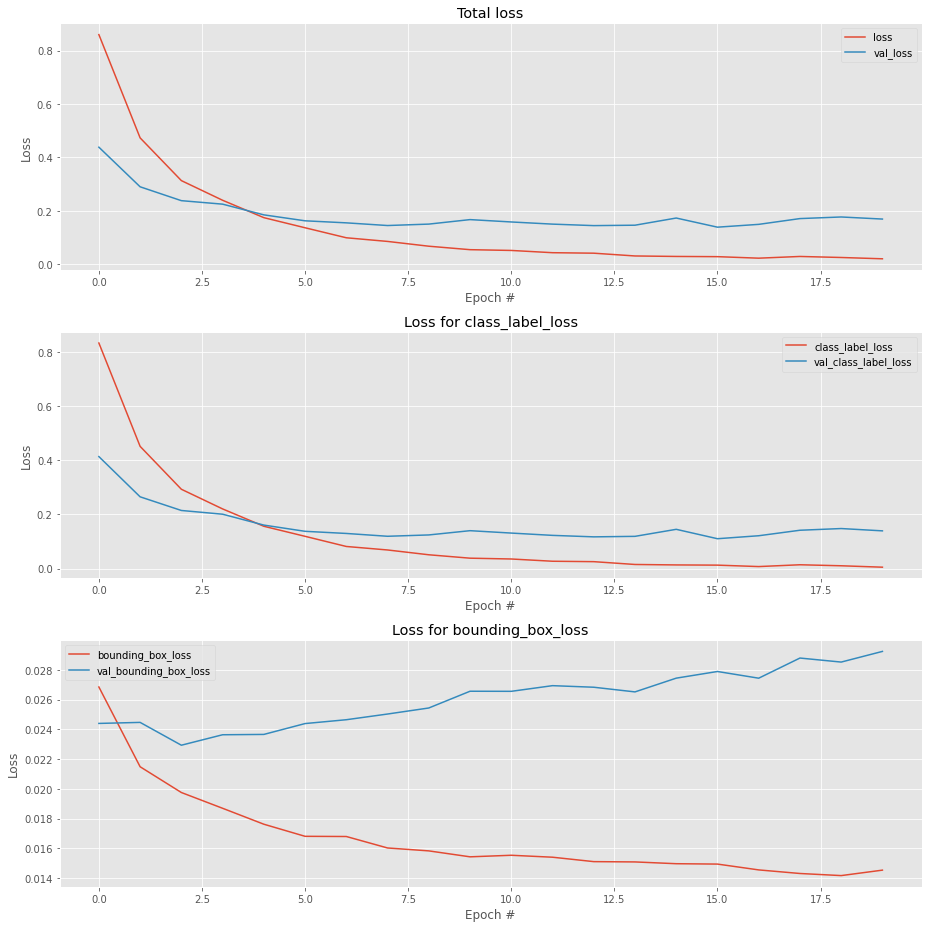

In [45]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
P = np.arange(0, 20)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(P, H.history[l], label=l)
	ax[i].plot(P, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

# display the plot
plt.tight_layout()
plt.show()

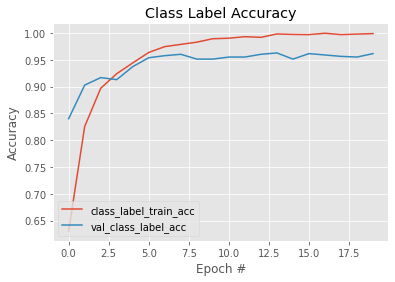

In [46]:
plt.style.use("ggplot")
plt.figure()
plt.plot(P, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(P, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# display the plot
plt.show()

In [47]:
test_images_dir = '/content/Test_Images/'
test_df.head()
testImageIds = test_df['Image_ID'].to_numpy().tolist()
testImageIds
ids = []
label = []
xmin = []
confidence = []
ymin =[]
xmax= []
ymax=[]
count = 0
for tid in testImageIds:
  imagePath = test_images_dir+tid+'.jpg'
  image = load_img(imagePath, target_size=(224,224))
  image = img_to_array(image)
  image = np.array(image, dtype='float32')/255.0
  image = np.expand_dims(image,axis=0)
  prediction = model.predict(image)
  startX,startY,endX,endY = prediction[0][0]
  image = cv2.imread(imagePath)
  (h,w) = image.shape[:2]
  xmin.append(startX*w)
  ymin.append(startY*h)
  xmax.append(endX*w)
  ymax.append(endY*h)
  ids.append(tid)
  ce = np.amax(prediction[1][0])
  confidence.append(ce)
  idx = np.argmax(prediction[1][0])
  classes = ["fruit_brownspot","fruit_healthy","fruit_woodiness"]
  label.append(classes[idx])
  count += 1

In [48]:
solution = pd.DataFrame({'Image_ID':ids})
solution['class'] = label
solution['confidence'] = confidence
solution['ymin'] = ymin
solution['xmin'] = xmin
solution['ymax'] = ymax
solution['xmax'] = xmax

In [49]:
submission = solution.copy()


In [50]:
submission.rename({0:'Image_ID'},axis='index')
submission.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_IUJJG62B,fruit_healthy,1.000000,234.025620,296.703064,406.523224,427.350433
1,ID_ZPNDRD4T,fruit_healthy,0.999999,243.105835,163.132736,386.777191,331.243347
2,ID_AHFYB64P,fruit_woodiness,0.984958,229.534836,172.696045,427.632202,354.729736
3,ID_L8JZLNTF,fruit_healthy,0.999954,187.319885,125.915863,362.423126,323.536621
4,ID_IFMUXGPL,fruit_woodiness,0.999988,133.666077,200.403519,400.141541,384.705872


In [51]:
submission.to_csv('submission_vgg16.csv', index=False)